# Project 2 - Coronavirus

This project consist to estimate the SIR model with data from WHO.

In [1]:
import pandas as pd
import numpy as np
from scipy import integrate
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, median_absolute_error
from scipy.integrate import odeint
from scipy.optimize import differential_evolution, minimize
import matplotlib.pyplot as plt

In [2]:
import PDEparams as pde

## Estimacion de parametros.
Tomaremos los datos de Brazil en la siguente liga https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases?force_layout=desktop, usaremos el modelo de SIR y estimaremos los parametros por medio de los datos.

### Definiendo e modelo.

S: Suceptibles, son las personas que podrian tener la enfermedad.

I: Infectados, personas con la enfermedad.

R: Recuperados, personas que tuvieron la enfermedad y ahora se han recuperado.

El modelo esta formado por las siguetes ecuaciones

$$\begin{align}
\frac{\mathrm{d} S}{\mathrm{d} t} &= -\beta\, \frac{SI}{N}\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \beta\, \frac{SI}{N} - \gamma\,I\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma\,I
\end{align}$$


Susceptible -> Infected -> Recovered

$$\begin{align}
\beta &= \text{Contact Rate } \times \text{ Probability of Transmission}\\
\gamma &= \text{Recovery Rate}
\end{align}$$

Incubation Period: 1-14 Days, most commonly 5 days (WHO)

In [71]:
df = pd.read_csv('BrazilCovid2.csv')

df

,Confirmados,Recuperados
0,3058,10980
1,2105,0
2,3257,0
3,2976,0
4,1996,8104
...,...,...
90,41857,32174
91,39924,26673
92,45403,47433
93,34177,30989


In [72]:
N= 6320000 #Poblacion total en Brasil(Rio de Janeiro)

S = np.arange(len(df))
for i in range(0,len(df)):
    if i == 0:
        S[i]= N - df.Confirmados[i] - df.Recuperados[i]
    else:
        S[i]= S[i-1] - df.Confirmados[i] - df.Recuperados[i]

In [73]:
N = 209500000 #poblacion total de brasil

data = {'Suceptibles' : S ,
        'Infectados' : df.Confirmados ,
        'Recuperados' : df.Recuperados }

df = pd.DataFrame(data)

df

,Suceptibles,Infectados,Recuperados
0,6305962,3058,10980
1,6303857,2105,0
2,6300600,3257,0
3,6297624,2976,0
4,6287524,1996,8104
...,...,...,...
90,3098059,41857,32174
91,3031462,39924,26673
92,2938626,45403,47433
93,2873460,34177,30989


In [74]:
def BrazilCovid(z, t, b, g):
    '''The input z corresponds to the current state of the system, z = [S, I, R]. Since the input is in 1D, no 
    pre-processing is needed.
    
    t is the current time.
    
    a and b correspond to the unknown parameters.
    '''
    
    S, I, R = z
    
    return [-b*S*I /N, b*S*I /N-g*I,  g*I]

### Condiciones iniciales

In [75]:
def initial_S():  #suceptibles
    return N-3058-10980

def initial_I():  #infectados
    return 3058

def initial_R():  #recuperados
    return 10980

In [76]:
my_model = pde.PDEmodel(df, BrazilCovid, [initial_S, initial_I, initial_R], bounds=[(0, 5), (0,5)], 
                        param_names=[r'$b$', r'$g$'], nvars=3, ndims=0, nreplicates=1, obsidx=None, outfunc=None)

## Aproximando los parametros

In [77]:
%%time
my_model.fit()

        $b$       $g$
0  2.486696  4.124614
Wall time: 2min 41s


In [78]:
my_model.best_params

,$b$,$g$
0,2.486696,4.124614


In [79]:
my_model.best_error

inf

In [80]:
%%time
my_model.likelihood_profiles(npoints=10)



Wall time: 55min 48s


In [81]:
my_model.result_profiles

,parameter,value,error
0,$b$,0.000000,inf
1,$b$,0.555556,inf
2,$b$,1.111111,inf
3,$b$,1.666667,inf
4,$b$,2.222222,inf
5,$b$,2.777778,inf
6,$b$,3.333333,inf
7,$b$,3.888889,inf
8,$b$,4.444444,inf
9,$b$,5.000000,inf


## Comparacion datos reales y el modelo


In [118]:
# Tomamos los valores del modelo
beta = my_model.best_params.iloc[0,0]
gamma = my_model.best_params.iloc[0,1]

In [129]:
#Condiciones indiciales
I_0 = 3058
R_0 = 10980
S_0= N - I_0 - R_0
z_0 = S_0, I_0, R_0
t = np.linspace(0, len(df), len(df))

In [130]:
# Integrate the SIR equations over the time grid, t.
ret = odeint(BrazilCovid, z_0, t, args=(beta, gamma))
S, I, R = ret.T

ValueError: x and y must have same first dimension, but have shapes (145,) and (95,)

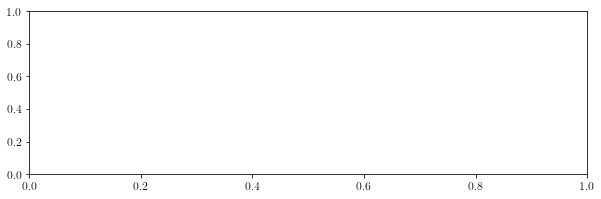

In [131]:
fig = plt.figure(figsize=(10,3))
plt.plot(t, df.Infectados, '-ok', color='r', label='Infectados reales', lw = 1)
plt.plot(t, I/1000, color = 'r', label='Infectados modelo SIR', lw = 1)
plt.xlabel('Días')
plt.ylabel('Personas')
plt.legend()
plt.show()

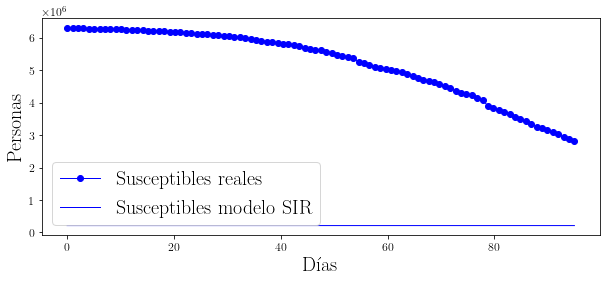

In [128]:
plt.figure(figsize=(10,4))
plt.plot(t, df.Suceptibles, '-ok', color='b', label='Susceptibles reales', lw = 1)
plt.plot(t, S/1000, color = 'b', label='Susceptibles modelo SIR', lw = 1)
plt.xlabel('Días')
plt.ylabel('Personas')
plt.legend()
plt.show()

## Conclusiones

Debido a que en la tabla my_model.result_profiles, los valores de $\beta$ y $\gamma$ no estan cerca de un valor specifico y el valor del error para el modelo es demasiado grande. No es porsible identificar los parametros del modelo o las aproximaciones no son muy buenas.